In [ ]:
import torch
import cv2
import numpy as np

In [ ]:
# Reading an image from a given file path--in greyscale
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return img

The reason for greyscale is that greyscale images have only one channel: intensity,
ranging from 0 (black) to 255 (white). So we are working with a 2D vector of pixels, 
which has a single value for intensty

In [ ]:
# Normalizing intensities
def normalize_image(img):
    img_normalized = img / 255.0 # Making intensity ranges [0, 1]
    return img_normalized

Normalizing the pixel values helps to stabilize the computations during 
the SVD decomposition and reconstruction. Since the values are now in the range [0, 1], 
they are less likely to cause numerical instability or large variations during the SVD process.

In [ ]:
# SVD decomposition after normalization
def svd_decomposition(img_normalized):
    U, S, V = torch.svd(torch.tensor(img_normalized, dtype=torch.float32))
    return U, S, V

The PyTorch library handles the singular value decomposition! We just need to store the matrices U,S,V.

In [ ]:
# Function to compress an image using a specified number of singular values
def compress_image(U, S, V, num_singular_values):
    compressed_U = U[:, :num_singular_values] # The first num_singular_rows columns of U
    compressed_S = torch.diag(S[:num_singular_values]) # Diagonal matrix with the first num_singular_values of S
    compressed_V = V[:, :num_singular_values].T # The first num_singular_values rows of V and transposes it
    return compressed_U, compressed_S, compressed_V

This code just takes a specified number, num_singular_values, and does the following:
    1) Takes the first num_singular_columns of U
    2) Turns S into a diagonal matrix that has the first num_singular_values singular values
    3) Takes the first num_singular_values rows of V and transposes it because we need V^T

In [ ]:
# Reconstruct an image from its compressed SVD components
def reconstruct_image(compressed_U, compressed_S, compressed_V):
    # The below line is basically multiplying the compressed U S V
    # mm stands for "matrix multiplication"
    img_compressed = torch.mm(compressed_U, torch.mm(compressed_S, compressed_V))
    
    # The line below looks comlicated, but it just converts the normalized image
    # back to an image with pixel values [0, 255]
    img_reconstructed = (img_compressed * 255).clamp(0, 255).numpy().astype(np.uint8)
    return img_reconstructed

The code above basically multiplies the "compressed" matrices. Then, since the image was previosly
normalized by dividing by 255, this time we multiply by 255 to get it back to the greyscale image format.
Finally, we return the image. The intensity entries are again in range [0, 255], integers.

In [ ]:
# Save the file
def save_image(img, file_path):
    cv2.imwrite(file_path, img)

In [ ]:
input_file = "/Users/hbzengin/src/michigan/math214/image_compression/cat.jpeg"
greyscale_file = "/Users/hbzengin/src/michigan/math214/image_compression/cat-greyscale.jpeg"
output_file = "/Users/hbzengin/src/michigan/math214/image_compression/cat-compressed.jpeg"

# The value here determines the compression amount. The smaller it is, the greater the compression
num_singular_values = 10

In [ ]:
img = read_image(input_file)
save_image(img, "/Users/hbzengin/src/michigan/math214/image_compression/cat-greyscale.jpeg") # turning old to greyscale and saving

In [ ]:
def main():
    
    # Calling previously defined functions below
    
    img_normalized = normalize_image(img)
    
    # SVD and compression
    U, S, V = svd_decomposition(img_normalized)
    compressed_U, compressed_S, compressed_V = compress_image(U, S, V, num_singular_values)
    
    # Reconstruction and saving
    img_reconstructed = reconstruct_image(compressed_U, compressed_S, compressed_V)
    save_image(img_reconstructed, output_file)
    
if __name__ == "__main__":
    main()


In [ ]:
import os # to show the size of the image before and after compression
from IPython.display import Image # to display the actual image

In [ ]:
Image(greyscale_file)

In [ ]:
old_size = (os.path.getsize(greyscale_file) / (1024*1024))# this function returns bytes, converting to megabytes

print(f"The old size of the image is {old_size: .2f} megabytes")

The old size of the image is  1.77 megabytes


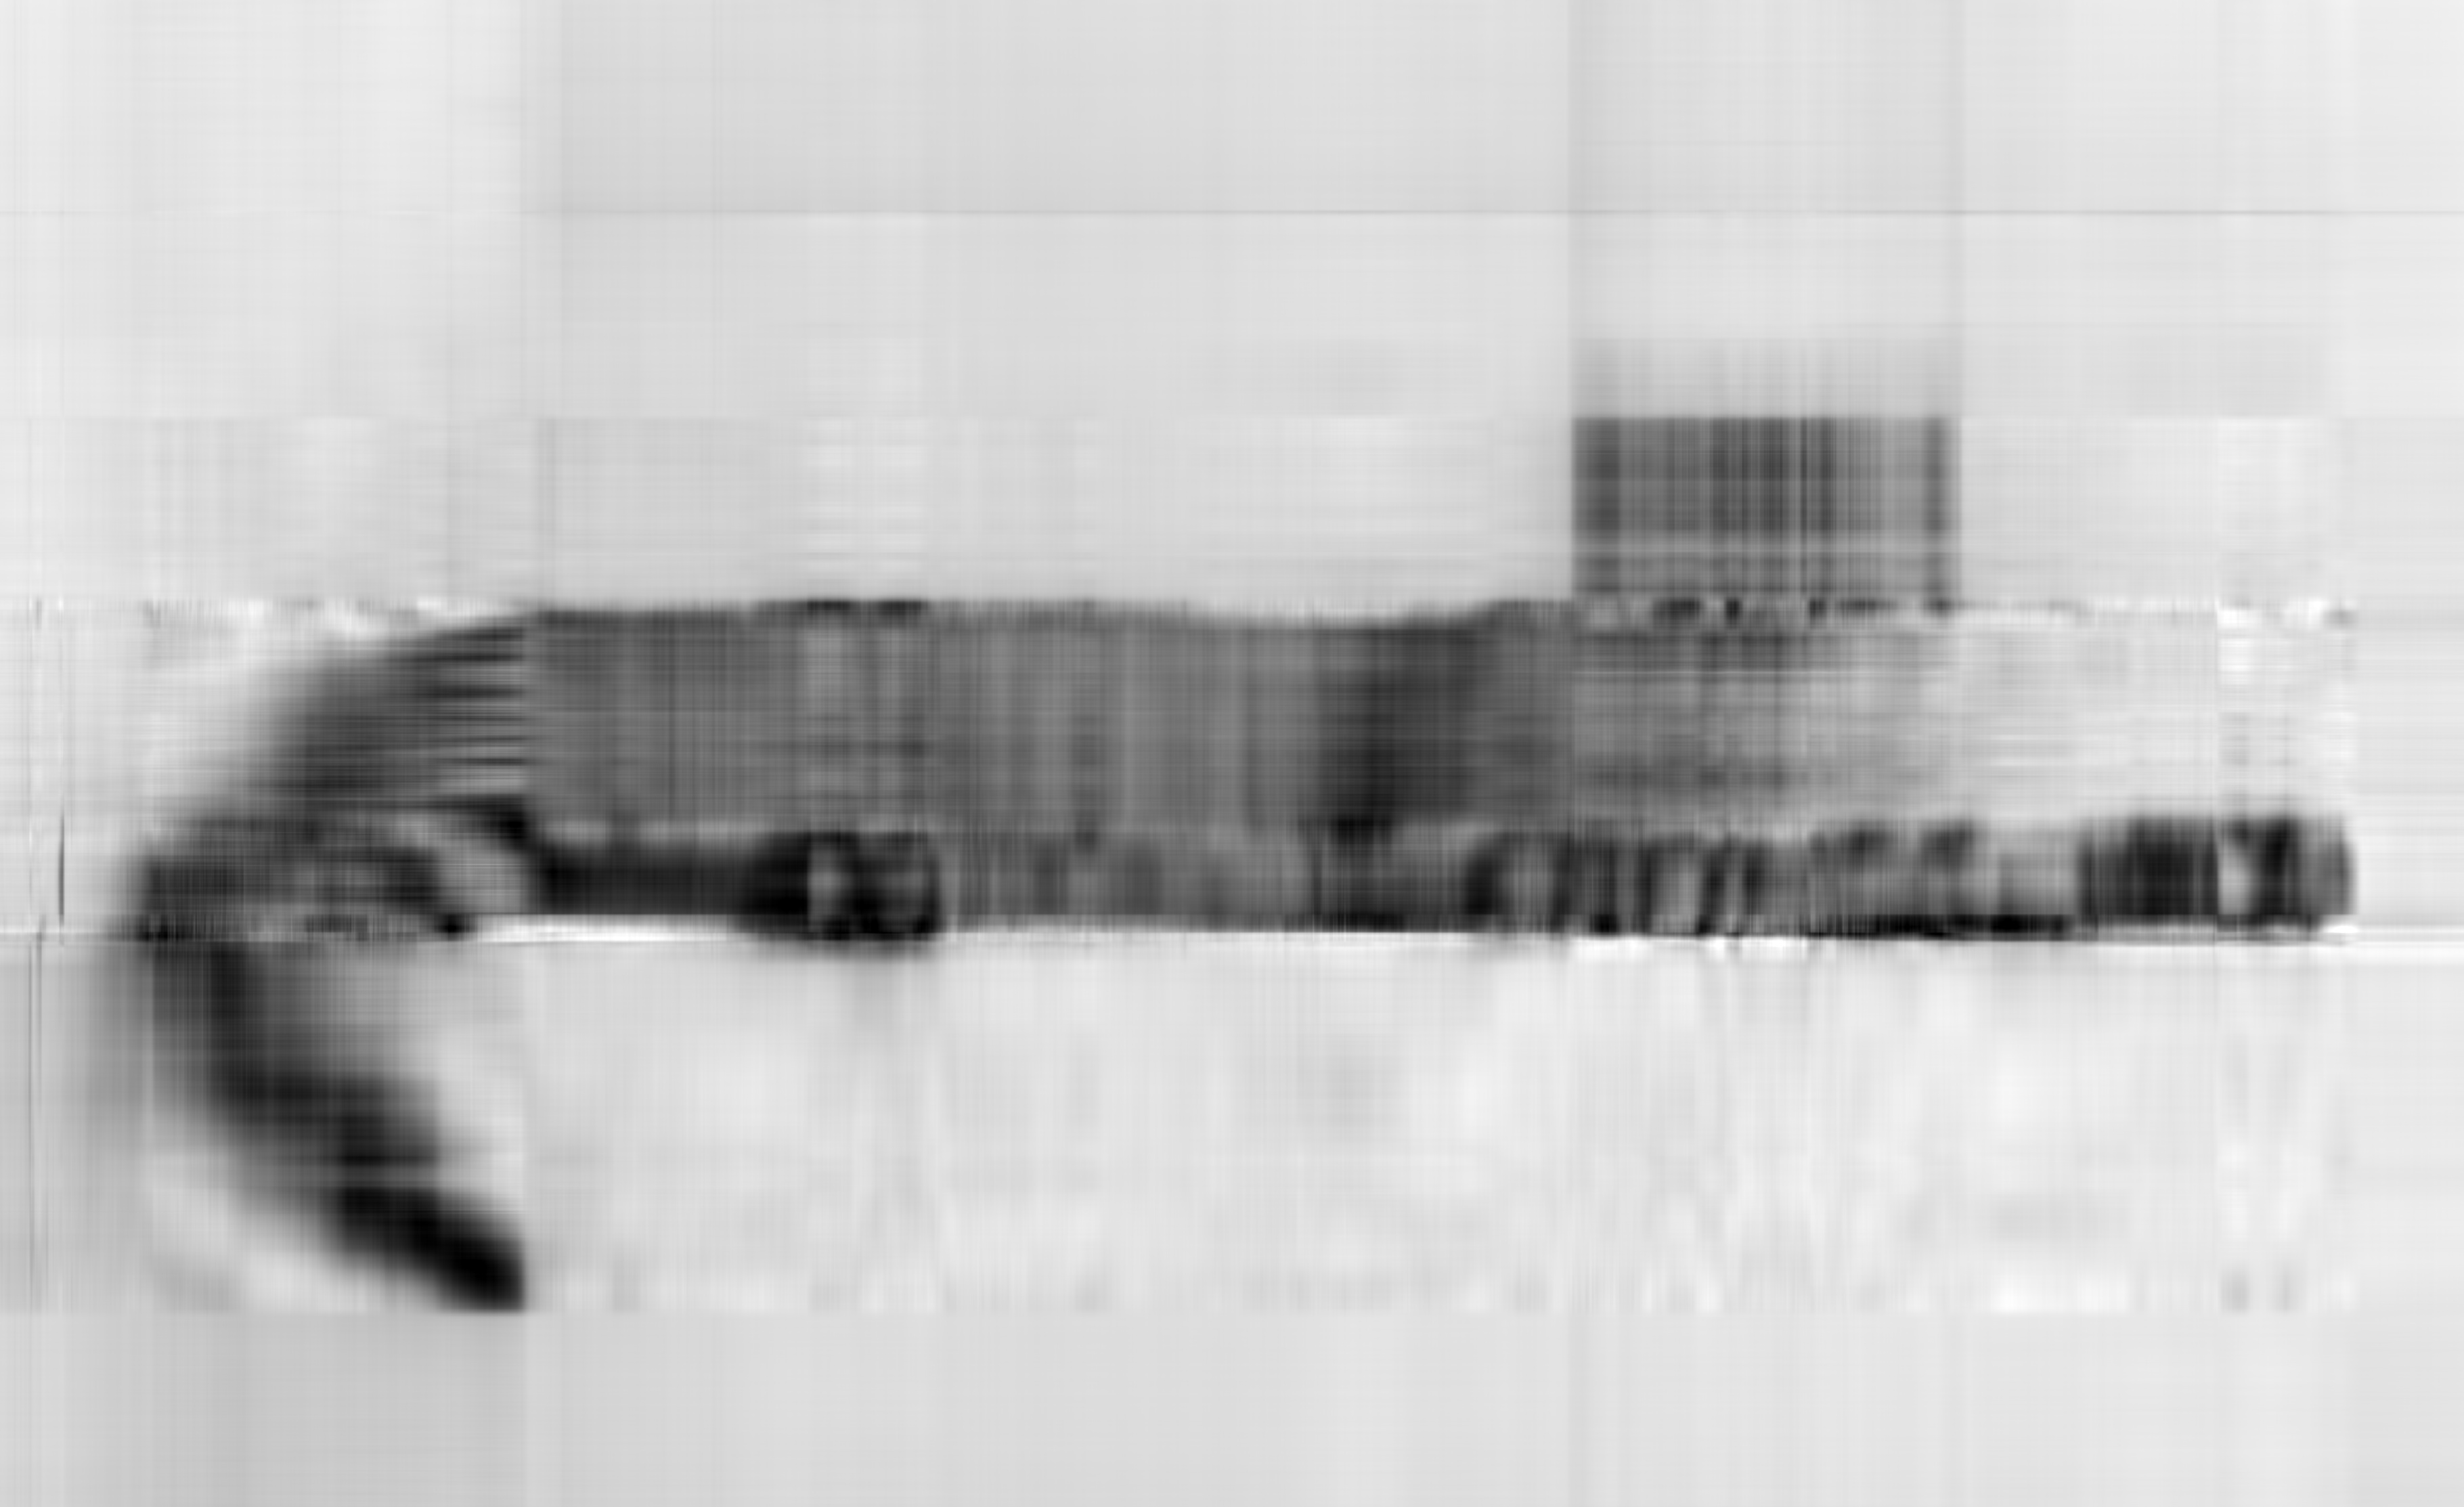

In [ ]:
Image(filename='/Users/hbzengin/src/michigan/math214/image_compression/cat-compressed.jpeg')

In [ ]:
new_size = (os.path.getsize(output_file) / (1024*1024))# this function returns bytes, converting to megabytes

print(f"The new size of the image is {new_size: .2f} megabytes")

The new size of the image is  0.67 megabytes
